Imagine we have a tile of locations, say "cortical columns" that tile the visual field. 

Each column represents a patch of the full visual space. And each patch encodes the visual features with the same set of sparse filters and code words.



In [132]:
from __future__ import division

import scipy
import time
import utils
import hrr_utils
import sklearn
import sklearn.metrics as metrics
import numpy as np
import imnet_utils as imut

from pylab import *
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from sklearn.datasets import load_digits
from mnist import MNIST
import matplotlib.pyplot as plt 

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})


In [245]:
NUM_CLASSES = 10

def load_dataset():
    mndata = MNIST('data/mnist/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    X_train = np.resize(X_train, (X_train.shape[0], 28, 28))
    X_test = np.resize(X_test, (X_test.shape[0], 28, 28))
    return (X_train, labels_train), (X_test, labels_test)

def load_patches(imgs, num_imgs, labels, patch_size=(5,5)):
    im_patches = np.zeros((patch_size[0], patch_size[1], num_imgs))
#     indices = np.random.choice(imgs.shape[0], num_imgs, replace=False)
    indices = np.random.choice(imgs.shape[0], num_imgs, replace=True)
    new_labels = []
    for i in range(num_imgs):
        new_labels.append(labels[indices[i]])
        im = imgs[indices[i]]
        randr_st = np.random.randint(im.shape[0] - patch_size[0]-1)
        randc_st = np.random.randint(im.shape[1] - patch_size[1]-1)
        im_patches[:,:,i] = im[randr_st:(randr_st + patch_size[0]), 
                                    randc_st:(randc_st + patch_size[1])]
    return im_patches+1, np.array(new_labels)
    
def load_random_patches(train, test, train_labels, test_labels, num_imgs=10, patch_size=(5,5)):
    train_patches, train_is = load_patches(train, int(num_imgs*.8), train_labels, patch_size)
    test_patches, test_is = load_patches(test, int(num_imgs*.2), test_labels, patch_size)
    return train_patches, test_patches, train_is, test_is

def clip(img):
    cimg = img.copy()
    cimg[cimg > 1] = 1
    cimg[cimg < 1] = -1
    return cimg

def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

In [246]:
(X_train, labels_train), (X_test, labels_test) = load_dataset()

In [247]:
print X_train.shape

(60000, 28, 28)


In [248]:
reload(imut)
patch_size=(5,5)
num_imgs=100000
tstart = time.time()

train_impatches, test_impatches, _, _ = load_random_patches(X_train, X_test, labels_train, labels_test, num_imgs, patch_size=patch_size)

# take a random number, then take a random patch in the number, then do that 100k times

print "Duration: ", time.time() - tstart


Duration:  0.554961919785


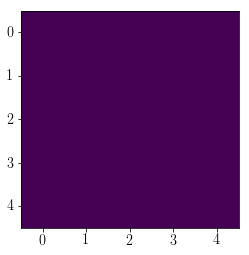

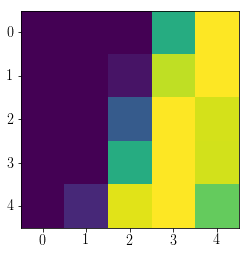

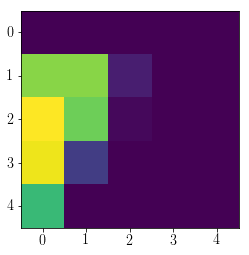

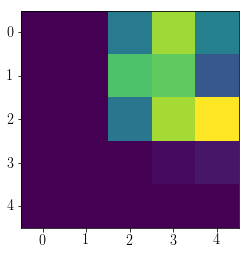

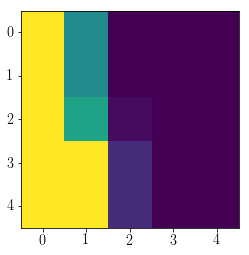

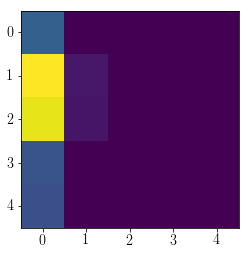

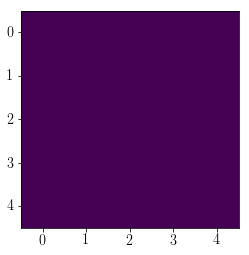

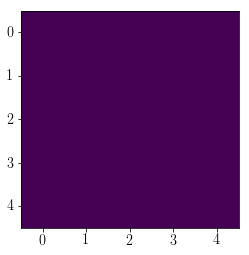

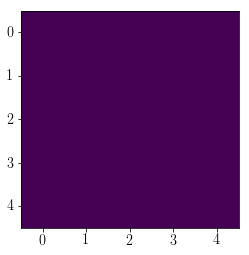

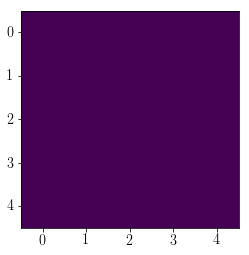

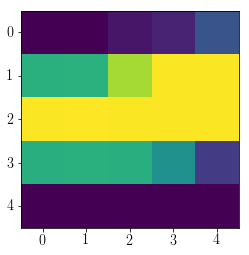

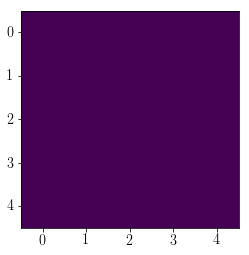

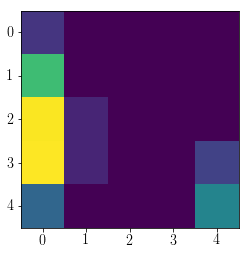

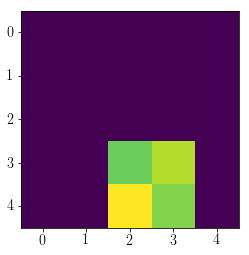

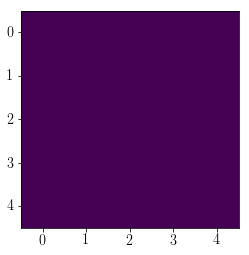

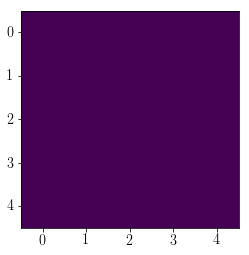

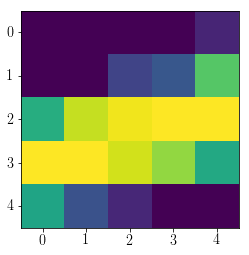

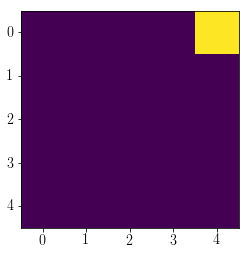

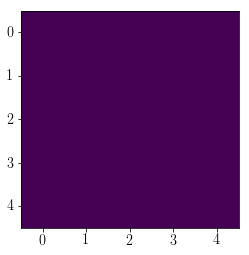

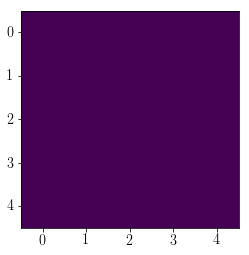

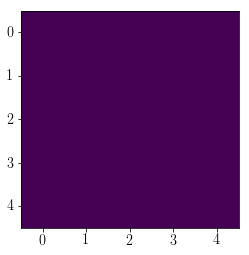

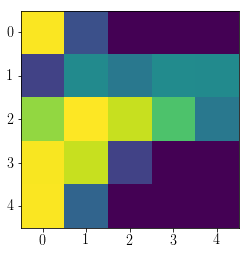

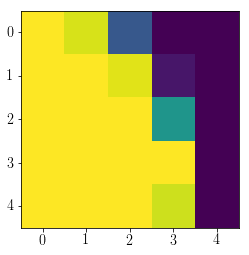

KeyboardInterrupt: 

In [41]:
# for i in range(test_impatches.shape[2]):
#     plt.figure()
#     plt.imshow((test_impatches[:,:,i]-1)/255)
#     plt.show()

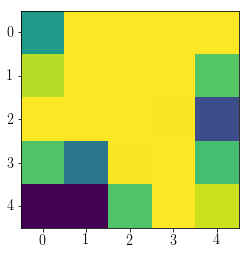

In [249]:
tims = train_impatches-1

imshow(tims[:,:,0])


(25, 80000)


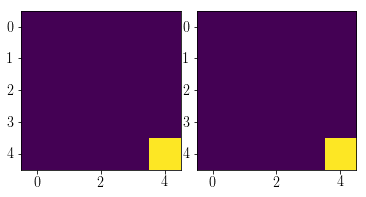

In [250]:
impatchr = train_impatches.copy().reshape((-1, train_impatches.shape[2]))
print impatchr.shape
impatchr -= 1
#impatchr /= 255

im_show = 16

irec = impatchr[:,im_show].reshape((train_impatches.shape[0], train_impatches.shape[1]))

subplot(121)
imshow((train_impatches[:,:,im_show]-1))
subplot(122)
imshow(irec)

In [251]:
mean01 = impatchr.mean()
impatchr -= mean01


In [252]:
ncomponents = min(25, patch_size[0]*patch_size[1])

#pca_encoder = TruncatedSVD(ncomponents)
pca_encoder = PCA(ncomponents)
fica_encoder = FastICA(ncomponents)

In [253]:
tstart = time.time()
pca_encoder.fit(impatchr.T)
print 'Duration: ', time.time() - tstart

Duration:  0.103605031967


In [254]:
scores = pca_encoder.transform(impatchr.T)

In [255]:
pc_comp = pca_encoder.components_

print pc_comp.shape

pc_comp_ims = pc_comp.T.reshape((train_impatches.shape[0], train_impatches.shape[1], -1))



(25, 25)


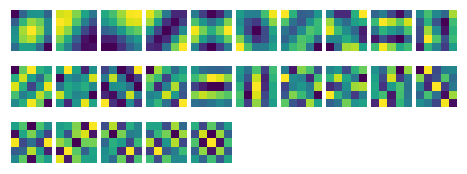

In [256]:
plt.rcParams['figure.subplot.hspace'] = 0.1
plt.rcParams['figure.subplot.wspace'] = 0.1

figure(figsize=(8,3))

nshow = 25
maxrow = 10
for i in range(nshow):
    ax=subplot(nshow//(maxrow-1)+1,maxrow,i+1)
    imshow(norm_range(pc_comp_ims[:,:,i]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)


In [257]:
tstart = time.time()
which_pcs = arange(20) #np.arange(scores.shape[1])
fica_encoder.fit(scores[:,which_pcs])
print 'Duration: ', time.time() - tstart


Duration:  3.01726293564


In [258]:
ic_scores = fica_encoder.transform(scores[:,which_pcs])

In [259]:
pc_scores = scores[:ic_scores.shape[0], :ic_scores.shape[1]]


In [260]:
ic_comp = fica_encoder.components_
ic_comp /= ic_comp.std(axis=0)
ic_comp = np.dot(ic_comp, pc_comp[which_pcs,:])
print ic_comp.shape

(20, 25)


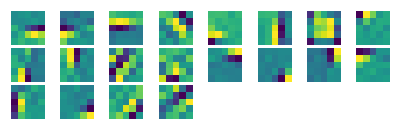

In [261]:
ic_comp_ims = ic_comp.T.reshape((train_impatches.shape[0], train_impatches.shape[1], -1))
figure(figsize=(7,2))
nshow = len(which_pcs) #min(len(which_pcs), 240)
maxrow = 8
for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    imshow(norm_range(ic_comp_ims[:,:,i+0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

In [262]:
reload(imut)
nrecon = 16
ic_c = linalg.lstsq(ic_comp.T, impatchr)
pc_c = linalg.lstsq(pc_comp[which_pcs,:].T, impatchr)
ic_code = ic_c[0].T
pc_code = pc_c[0].T

In [265]:
print (ic_comp.shape, impatchr.shape, ic_code.shape, pc_code.shape)

((20, 25), (25, 80000), (80000, 20), (80000, 20))


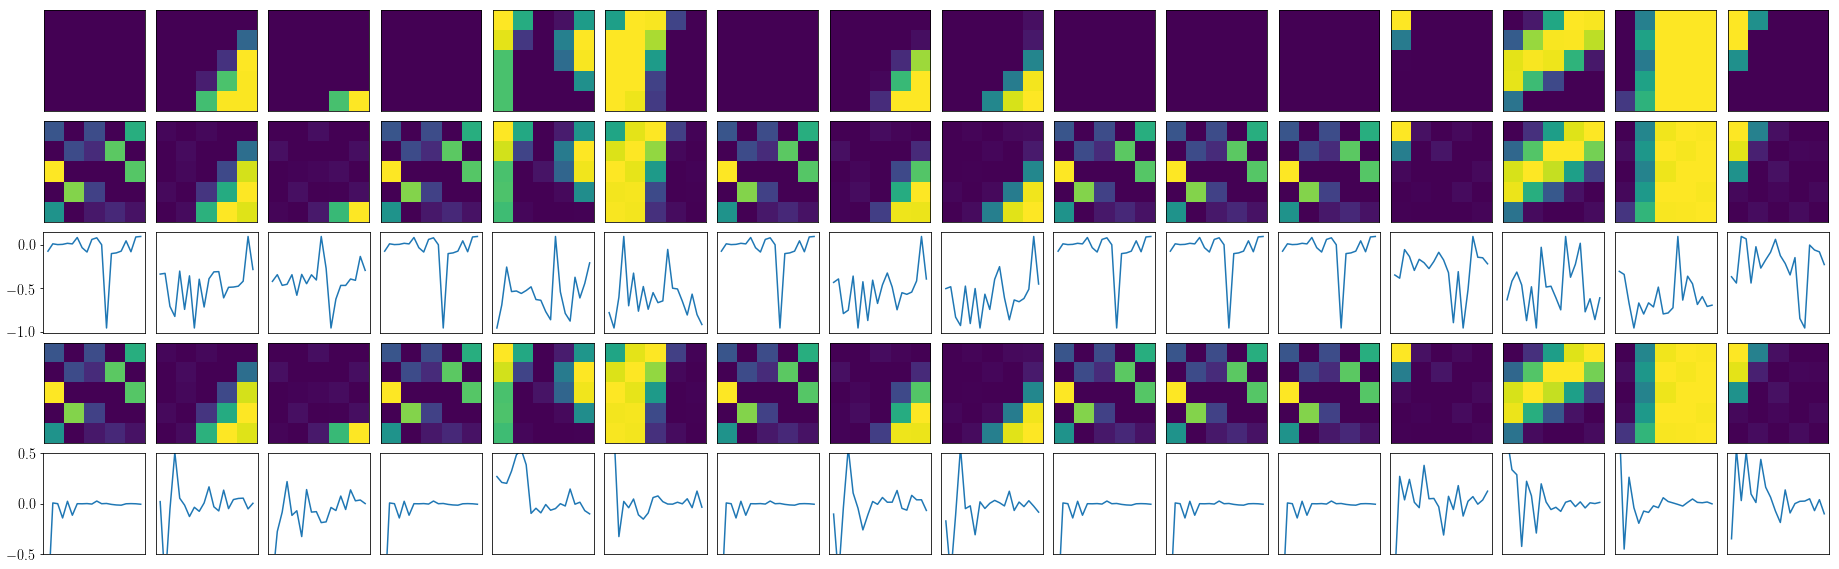

In [115]:


figure(figsize=(32, 10))

for imx in range(nrecon):
    
    ax = subplot(5, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1])
    imshow(imp)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1])
    ic_reconr += mean01
    ic_reconr[ic_reconr<0] = 0
    ic_reconr[ic_reconr>1] = 1
    imshow(ic_reconr)
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(5, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    #ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

    ax = subplot(5, nrecon, imx + 1 + 3*nrecon)
    pc_recon = np.dot(pc_code[imx,:], pc_comp[which_pcs,:])
    pc_reconr = pc_recon.reshape(patch_size[0], patch_size[1])
    pc_reconr += mean01
    pc_reconr[pc_reconr<0] = 0
    pc_reconr[pc_reconr>1] = 1
    
    imshow(norm_range(pc_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + 4*nrecon)
    plot(pc_code[imx,:].T/norm(pc_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])


In [116]:
ic_reconr.max()

1.0

/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


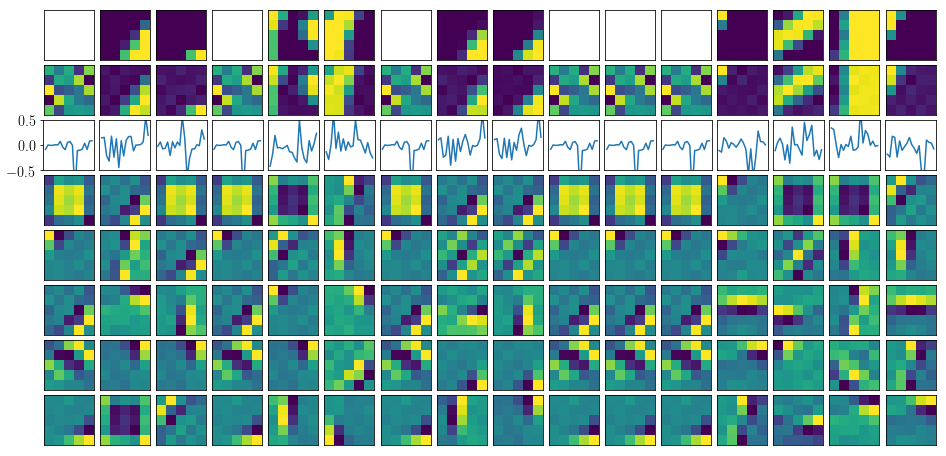

In [117]:
figure(figsize=(16, 8))

ic_ex = 2*arange(5)+1
nrows = 3 + len(ic_ex)
for imx in range(nrecon):
    
    ax = subplot(nrows, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1])
    imshow(imp)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(nrows, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1])
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(nrows, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

          
    idx_max = np.argsort(abs(ic_code[imx,:]))
  
    for ici,icx in enumerate(ic_ex):
        ax = subplot(nrows, nrecon, imx + 1 + (3+ici)*nrecon)
        ic_compr = ic_comp[idx_max[-icx],:].reshape(patch_size[0], patch_size[1]) 
        ic_compr = ic_compr * ic_code[imx, idx_max[-icx]] # this just flips it if its negative
        imshow(norm_range(ic_compr))
        ax.set_xticks([])
        ax.set_yticks([])
    


In [44]:
def draw_ic_im(ic_coef, ic_comps, nx, ny, patch_size):
    im = np.zeros((int(ny*patch_size[1]), int(nx*patch_size[0])))
    
    cfx = 0
    for ix in range(nx):
        for iy in range(ny):
            ic_recon = np.dot(ic_coef[cfx], ic_comps)
            ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1])
            
            ic_reconr = (ic_reconr + mean01)
            
            ic_reconr[ic_reconr<0] = 0 
            ic_reconr[ic_reconr>1] = 1
            
            
            im[iy*patch_size[1]:(iy+1)*patch_size[1], 
                      ix*patch_size[0]:(ix+1)*patch_size[0], :] = ic_reconr #norm_range(ic_reconr)
            cfx+=1
            
    return im


FHRR images

In [133]:
def fhrr_vec(D, N):
    # pick a random phase
    rphase = 2 * np.pi * np.random.rand(D, N // 2)

    fhrrv = np.zeros((D, 2 * (N//2)))
    fhrrv[:, :(N//2)] = np.cos(rphase)
    fhrrv[:, (N//2):] = np.sin(rphase)
    
    return fhrrv

def fhrr_inv(a):
    a = np.atleast_2d(a)
    
    N2 = a.shape[1] // 2
    b = np.zeros_like(a)
    b[:,:N2] = a[:, :N2]
    b[:,N2:] = -a[:, N2:]
    
    return b

def fhrr_bind(a, b, pa=1, pb=1):
    a = np.atleast_2d(a)
    b = np.atleast_2d(b)    
    
    # we want to do element wise multiply of complex numbers
    N2 = a.shape[1] // 2
    
    
    if not pa==1:
        a = fhrr_pow(a, pa)
        
    if not pb==1:
        b = fhrr_pow(b, pb)
  
    ra = a[:, :N2]
    ia = a[:, N2:]
    rb = b[:, :N2]
    ib = b[:, N2:]
              
    c = np.zeros_like(a)
    
    c[:, :N2] = ra * rb - ia * ib
    c[:, N2:] = ra * ib + rb * ia
    
    return c
 
    
def fhrr_pow(a, pa=1):
    a = np.atleast_2d(a)
    
    N2 = a.shape[1] // 2
    
    ra = a[:, :N2]
    ia = a[:, N2:]
    
    if not pa == 1:
        ma = (ra**2 + ia**2) ** (pa/2) 
        aa = pa * (np.arctan(ia/ra) + (ra < 0) * np.pi)
        ra = ma * np.cos(aa)
        ia = ma * np.sin(aa)
        
    c = np.zeros_like(a)
    c[:, :N2] = ra
    c[:, N2:] = ia
    
    return c
    
def fhrr_roll(a, r=1):
    a = np.atleast_2d(a)
    
    N2 = a.shape[1] // 2
    c = np.zeros_like(a)
    c[:, :N2] = np.roll(a[:, :N2], r, axis=1)
    c[:, N2:] = np.roll(a[:, N2:], r, axis=1)
    
    return c

def fhrr_cc(a, b):
    
    pass

def sparsify(x, tau=1):
    return 0.5*tau*(np.exp(x/tau) - np.exp(-x/tau))

Multiple Unbinding

In [134]:
N = 5000

objD = 120
trfD = 60

obj_vecs = 2 * (np.random.randn(objD, N) < 0) - 1
trf_vecs = 2 * (np.random.randn(trfD, N) < 0) - 1

# This sets the coefficients of the two bound vectors
b_objc = np.zeros(objD)
b_trfc = np.zeros(trfD)

# We'll turn two vectors on by giving them coefficients of 1
b_objc[10] = 1

b_trfc[14] = 1

bound_vec = np.dot(b_objc, obj_vecs) * np.dot(b_trfc, trf_vecs)

# By resonance, I mean positive feedback by having the eigenvectors grow and then be renormalized
# having the eigenvalues as 1 is good enough though (any positive value really e.g. it is 0 vs. 1)
eignorm = 1
obj_resonance = np.dot(np.dot(pinv(obj_vecs), eignorm * np.eye(objD)), obj_vecs)
trf_resonance = np.dot(np.dot(pinv(trf_vecs), eignorm * np.eye(trfD)), trf_vecs)

# So instead of setting the initial vectors to be the sum of all potential,
# we can just set it randomly
obj_state = np.random.randn(N)
trf_state = np.random.randn(N)

obj_state = obj_state / np.linalg.norm(obj_state)
trf_state = trf_state / np.linalg.norm(trf_state)


n_steps = 10

obj_coef_hist = np.zeros((n_steps, objD))
trf_coef_hist = np.zeros((n_steps, trfD))

thal_vec = np.zeros_like(bound_vec)

for i in range(n_steps):
    thal_vec[:] = bound_vec
    
    obj_coef_hist[i,:] = np.dot(obj_vecs, obj_state) / N**0.5
    trf_coef_hist[i,:] = np.dot(trf_vecs, trf_state) / N**0.5
    
    thal_vec -= trf_state * obj_state *N
    
    obj_state = np.dot(obj_resonance, trf_state * thal_vec + obj_state)

    trf_state = np.dot(trf_resonance, obj_state * thal_vec + trf_state) 

    

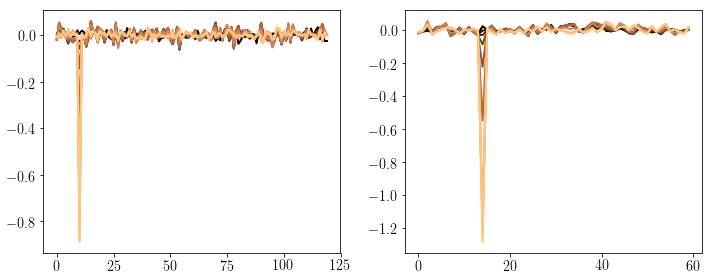

In [135]:
cols = get_cmap('copper', n_steps)

figure(figsize=(10,4))

for i in range(n_steps):
    subplot(121)
    plot(obj_coef_hist[i,:], c=cols(i), lw=2)
    subplot(122)
    plot(trf_coef_hist[i,:], c=cols(i), lw=2)

plt.tight_layout()

HD Map-Seeking Circuit

In [236]:
N=5000
icD = len(which_pcs)
ic_hyperpatch = fhrr_vec(icD, N)
ic_comphyperpatch = fhrr_vec(patch_size[0]*patch_size[1], N)
nx_patch = 8
ny_patch = 6

loc_hyperbase = fhrr_vec(2, N) #2*(np.random.randn(2, N) < 0) - 1

locD = nx_patch * ny_patch
loc_vecs = np.zeros((locD, N))
c=0
code_vecs = []

for ix in range(nx_patch):
    for iy in range(ny_patch):
        
        code_v = fhrr_bind(loc_hyperbase[[0],:], loc_hyperbase[[1],:], pa=(ix+1), pb=(iy+1))
        loc_vecs[c, :] = code_v
        c+=1
        
        ic_code = fhrr_bind(np.tile(code_v, (icD, 1)), ic_hyperpatch)
        
        
        code_vecs.append(ic_code)
        

In [137]:
def svd_whiten(X):

    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # U and Vt are the singular matrices, and s contains the singular values.
    # Since the rows of both U and Vt are orthonormal vectors, then U * Vt
    # will be white
    X_white = np.dot(U, Vt)

    return X_white

In [193]:
reload(imut)
patch_size=(5,5)
num_imgs=1000
tstart = time.time()

train_impatches, test_impatches, train_patchlabels, test_patchlabels = load_random_patches(X_train, X_test, labels_train, labels_test, num_imgs, patch_size=patch_size)

# take a random number, then take a random patch in the number, then do that 100k times

print "Duration: ", time.time() - tstart

Duration:  0.0077691078186


In [194]:
print train_impatches.shape

(5, 5, 800)


(5, 5, 69)
(5, 5, 85)
(5, 5, 85)
(5, 5, 81)
(5, 5, 81)
(5, 5, 64)
(5, 5, 91)
(5, 5, 75)
(5, 5, 88)
(5, 5, 81)


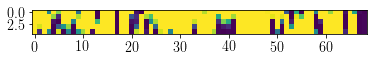

In [211]:
from scipy.misc import imresize

digits = [0,1,2,3,4,5,6,7,8,9]

digit_ims = {d : [] for d in digits}
dgim_size = (patch_size[0],patch_size[1])

for i in range(train_patchlabels.shape[0]):
    label = train_patchlabels[i]
    img = train_impatches[:,:,i].reshape((patch_size[0], patch_size[1])) - 1
    img *= -1

    digit_ims[label].append(img)

for digit, ims in digit_ims.items():
    digit_ims[digit] = np.dstack(ims)
    print digit_ims[digit].shape
    
plt.imshow(digit_ims[0][0])

In [319]:

which_pcs = arange(20)
icD = len(which_pcs)

digvecs = {i: np.zeros(N) for i in range(10)}
hd_iccomps = {i: np.zeros(N) for i in range(10)} # P
ic_codes = {i: np.zeros(N) for i in range(10)}
ic_comps = {i: np.zeros(N) for i in range(10)}
for digit in digit_ims.keys():
    imp = digit_ims[digit]
    impatchr = imp.reshape((patch_size[0]*patch_size[1], imp.shape[2])).copy()
    mean01 = impatchr.mean()
    impatchr[impatchr>mean01] = mean01
    impatchr -= mean01

    pca_encoder = PCA(ncomponents)
    pca_encoder.fit(impatchr.T)
    scores = pca_encoder.transform(impatchr.T)
    pc_comp = pca_encoder.components_

    fica_encoder = FastICA(ncomponents)
    fica_encoder.fit(scores[:,which_pcs])
    ic_scores = fica_encoder.transform(scores[:,which_pcs])
    ic_comp = fica_encoder.components_
    ic_comp /= ic_comp.std(axis=0)
    ic_comp = np.dot(ic_comp, pc_comp[which_pcs,:])

    ic_c = linalg.lstsq(ic_comp.T, impatchr)
    
    ic_comps[digit] = ic_comp
    hd_iccomps[digit] = np.dot(ic_comp, ic_comphyperpatch)
    ic_codes[digit] = ic_c[0].T
    digvecs[digit] = np.dot(ic_code[digit], ic_hyperpatch)


(20, 25)
(69, 20)
(20, 5000)
(69, 5000)


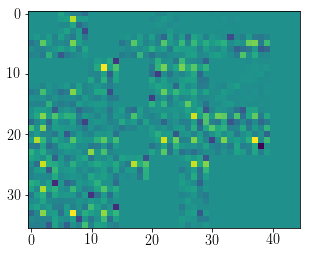

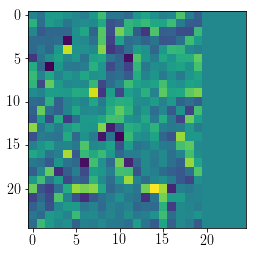

In [320]:
print ic_comps[0].shape
print ic_codes[0].shape
print hd_iccomps[0].shape 
print digvecs[0].shape
def grow_msc_image(patches):
    [num_patches, patch_area] = patches.shape
    total_area = num_patches*patch_area
    pr, pc = int(np.floor(np.sqrt(patch_area))), int(np.ceil(np.sqrt(patch_area)))
    m = int(np.ceil(np.sqrt(num_patches))*pr)
    n = int(np.ceil(np.sqrt(num_patches))*pc)
    msc = np.zeros((m,n))
    patchi = 0
    # euclidean direction
    for x in range(0,n,pc):
        for y in range(0,m,pr):
            if patchi == num_patches:
                break
            msc[y:y+pr, x:x+pc] = patches[patchi].reshape((pr,pc))
            patchi += 1
    return msc

def make_msc_image(patches):
    [num_comps, patch_area] = patches.shape

    total_area = num_comps*patch_area
    # image is a square because that's easiest. dependent on square patches
    s = int(np.ceil(np.sqrt(num_comps))*np.sqrt(patch_area))
    msc = np.zeros((s, s))
    patchi = 0
    # euclidean direction
    for x in range(0,s,patch_size[1]):
        for y in range(0,s,patch_size[0]):
            if patchi == num_comps:
                break
            msc[y:y+patch_size[0], x:x+patch_size[1]] = patches[patchi].reshape(patch_size)
            patchi += 1
    return msc

dynamic_mscs = {i: np.zeros(N) for i in range(10)}
for digit in dynamic_mscs.keys():  
    dynamic_mscs[digit] = grow_msc_image(ic_code[digit])
plt.figure()
plt.imshow(dynamic_mscs[0])
plt.show()

static_mscs = {i: np.zeros(N) for i in range(10)}
for digit in mscs.keys():
     static_mscs[digit] = make_msc_image(ic_comps[digit]) # each component has a patch
plt.figure()
plt.imshow(static_mscs[0])
plt.show()


In [321]:
print ic_comps[0].shape
print ic_codes[0].shape
print hd_iccomps[0].shape # P
print digvecs[0].shape


(20, 25)
(69, 20)
(20, 5000)
(69, 5000)


In [327]:
bound_iccode = {i: 0 for i in range(10)}
bound_iccomp = {i: 0 for i in range(10)}

for digit in bound_iccode.keys():
    bound_iccode[digit] = np.dot(ic_codes[digit].T, digvecs[digit])
    bound_iccomp[digit] = np.dot(ic_comps[digit].T, hd_iccomps[digit])
print (bound_iccode[0].shape, bound_iccomp[0].shape)

((20, 5000), (25, 5000))


In[937]
http://128.32.158.211:8888/notebooks/HDlanguageDetection/resonance_hdmsc-decorr-170131.ipynb